#Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chiraagkv","key":"5c450bf6f5b755fad6808b91a043b9d9"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vignonantoine/mediapipe-processed-asl-dataset

 98% 917M/935M [00:11<00:00, 30.4MB/s]
100% 935M/935M [00:11<00:00, 86.6MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mediapipe-processed-asl-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

# Data

In [7]:
data_dir = "/content/processed_combine_asl_dataset"

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)

train_data = train_datagen.flow_from_directory(
        data_dir,
        target_size=(256, 256),
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
        subset = 'training',
)
val_data = train_datagen.flow_from_directory(
        data_dir,
        target_size=(256, 256),
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
        subset = 'validation',
)

Found 79078 images belonging to 36 classes.
Found 26342 images belonging to 36 classes.


In [9]:
train_data.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

# Modelling

## Basic CNN

In [ ]:
baseline = tf.keras.Sequential([
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(36, activation="softmax")
])

baseline.compile(loss="categorical_crossentropy",
               optimizer=Adam(),
               metrics=["accuracy"])

history_b = baseline.fit(train_data, epochs=5, validation_data=val_data, steps_per_epoch=len(train_data)//10, validation_steps=len(val_data)//10)

Epoch 1/5
247/247 [==============================] - 28s 99ms/step - loss: 2.1886 - accuracy: 0.4104 - val_loss: 3.1951 - val_accuracy: 0.1425
Epoch 2/5
247/247 [==============================] - 24s 99ms/step - loss: 1.5299 - accuracy: 0.5855 - val_loss: 3.1021 - val_accuracy: 0.1947
Epoch 3/5
247/247 [==============================] - 24s 97ms/step - loss: 1.2321 - accuracy: 0.6631 - val_loss: 3.0226 - val_accuracy: 0.2161
Epoch 4/5
247/247 [==============================] - 23s 92ms/step - loss: 1.0506 - accuracy: 0.7132 - val_loss: 3.0331 - val_accuracy: 0.2416
Epoch 5/5
247/247 [==============================] - 24s 97ms/step - loss: 0.9087 - accuracy: 0.7589 - val_loss: 3.1136 - val_accuracy: 0.2264


<Axes: >

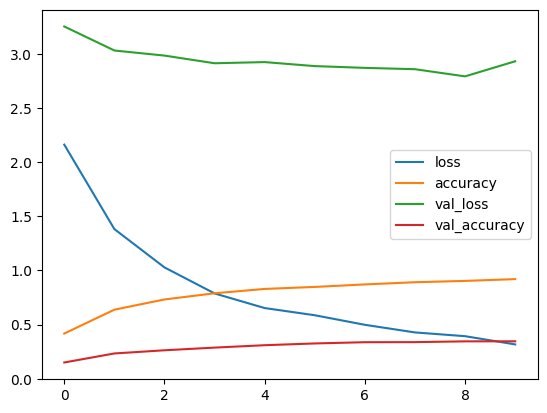

In [ ]:
pd.DataFrame(history_b.history).plot()

##ResNet

In [10]:
train_data.next()[0].shape

(32, 256, 256, 3)

In [11]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

inputs = tf.keras.Input(shape=[256,256,3], batch_size=32)
# inputs = tf.image.rgb_to_grayscale(inputs)
# inputs = tf.repeat([tf.expand_dims(tf.reduce_mean(train_data.next()[0], axis=-1), axis=-1)]*3, [1], axis=0)
# print(inputs.shape)
x = base_model(inputs)
x = Flatten()(x)
outputs = Dense(36, activation="softmax")(x)

resnet = tf.keras.Model(inputs, outputs)

94668760/94668760 [==============================] - 1s 0us/step


In [12]:
resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])
resnet_history = resnet.fit(train_data, epochs=7, validation_data=val_data, steps_per_epoch=len(train_data)//10, validation_steps=len(val_data)//10)

Epoch 1/7
247/247 [==============================] - 135s 399ms/step - loss: 1.3040 - accuracy: 0.6485 - val_loss: 4.6130 - val_accuracy: 0.3540
Epoch 2/7
247/247 [==============================] - 100s 405ms/step - loss: 0.5241 - accuracy: 0.8432 - val_loss: 1.2670 - val_accuracy: 0.6692
Epoch 3/7
247/247 [==============================] - 101s 410ms/step - loss: 0.3261 - accuracy: 0.9050 - val_loss: 1.1934 - val_accuracy: 0.7107
Epoch 4/7
247/247 [==============================] - 100s 404ms/step - loss: 0.2788 - accuracy: 0.9205 - val_loss: 1.6343 - val_accuracy: 0.6380
Epoch 5/7
 14/247 [>.............................] - ETA: 1:25 - loss: 0.1912 - accuracy: 0.9442

KeyboardInterrupt: ignored

<Axes: >

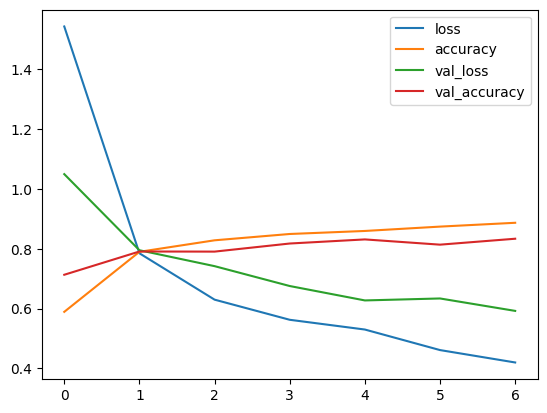

In [ ]:
pd.DataFrame(resnet_history.history).plot()

In [ ]:
resnet.save('/content/drive/MyDrive/resnet_model')

In [ ]:
loaded_model = tf.keras.models.load_model("resnet_model")

In [ ]:
loaded_model.evaluate(val_data)

824/824 [==============================] - 92s 111ms/step - loss: 0.5859 - accuracy: 0.8355


[0.5859158039093018, 0.835520327091217]

#Preds

In [ ]:
import os
classes = sorted([x[0][-1] for x in os.walk("/content/processed_combine_asl_dataset/")][1:])

In [ ]:
classes = [str(i) for i in list(range(10))] + [chr(i) for i in range(65, 91)]

In [ ]:
img = tf.keras.utils.load_img(
    "/content/processed_combine_asl_dataset/a/A1 (6).jpg", target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = img_array / 255
preds = resnet.predict(img_array)
classes[np.argmax(preds)], np.max(preds)

1/1 [==============================] - 0s 21ms/step


('a', 0.72074145)